# Plot

In [1]:
from pathlib import Path
import pandas as pd
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import json

from processing_utils import xyz_to_df, pairwise_distance, average_abs_dist, xyz_to_np

HARTREE_TO_KCAL_MOL = 627.509

In [2]:
experiments_path = Path("experiments")
processed_results_path = Path("processed_results")
molecules_path = Path("uniques_100_molecules_42_seed")

In [3]:
results_df = pd.read_csv(processed_results_path / "with_reference_results.csv")
results_df.head()

,molecule,parameter,factor,parameter value,atomisation energy (Hartrees),atomisation energy (kcal/mol),total energy (Hartrees),total energy (kcal/mol),max atomic force,VQM24 atomisation energy (Hartrees),VQM24 atomisation energy (kcal/mol),VQM24 total energy (Hartrees),VQM24 total energy (kcal/mol),VQM24 pairwise distance,Atomization Energy MAE (Hartrees),Atomization Energy MAE (kcal/mol),Total Energy MAE (Hartrees),Total Energy MAE (kcal/mol)
0,FNxOSiSxH2_82,gam3d2,1.5,0.375,1.360410,853.669459,17.632961,11064.841710,0.019270,0.866469,543.716929,1.463972,918.655654,NaN,0.493941,309.952530,16.168989,10146.186056
1,CNPSi2H4_113,gam3d2,1.5,0.375,2.177525,1366.416468,12.990552,8151.688164,0.041210,1.135908,712.792304,1.618339,1015.522367,NaN,1.041617,653.624164,11.372213,7136.165797
2,COPx2SyH4_72,gam3d2,1.5,0.375,1.824700,1145.015747,16.395235,10288.157496,0.063239,0.950140,596.221114,1.906659,1196.445470,NaN,0.874561,548.794634,14.488576,9091.712026
3,CN2PSH1_54,gam3d2,1.5,0.375,1.767131,1108.890316,14.221133,8923.888776,0.074708,0.847112,531.570446,1.414629,887.692235,NaN,0.920018,577.319870,12.806504,8036.196541
4,C2SiSx2H8_221,gam3d2,1.5,0.375,2.089762,1311.344399,16.199616,10165.404942,0.195071,1.495457,938.412543,1.859328,1166.744879,NaN,0.594305,372.931857,14.340288,8998.660063


## Atomisation Energy

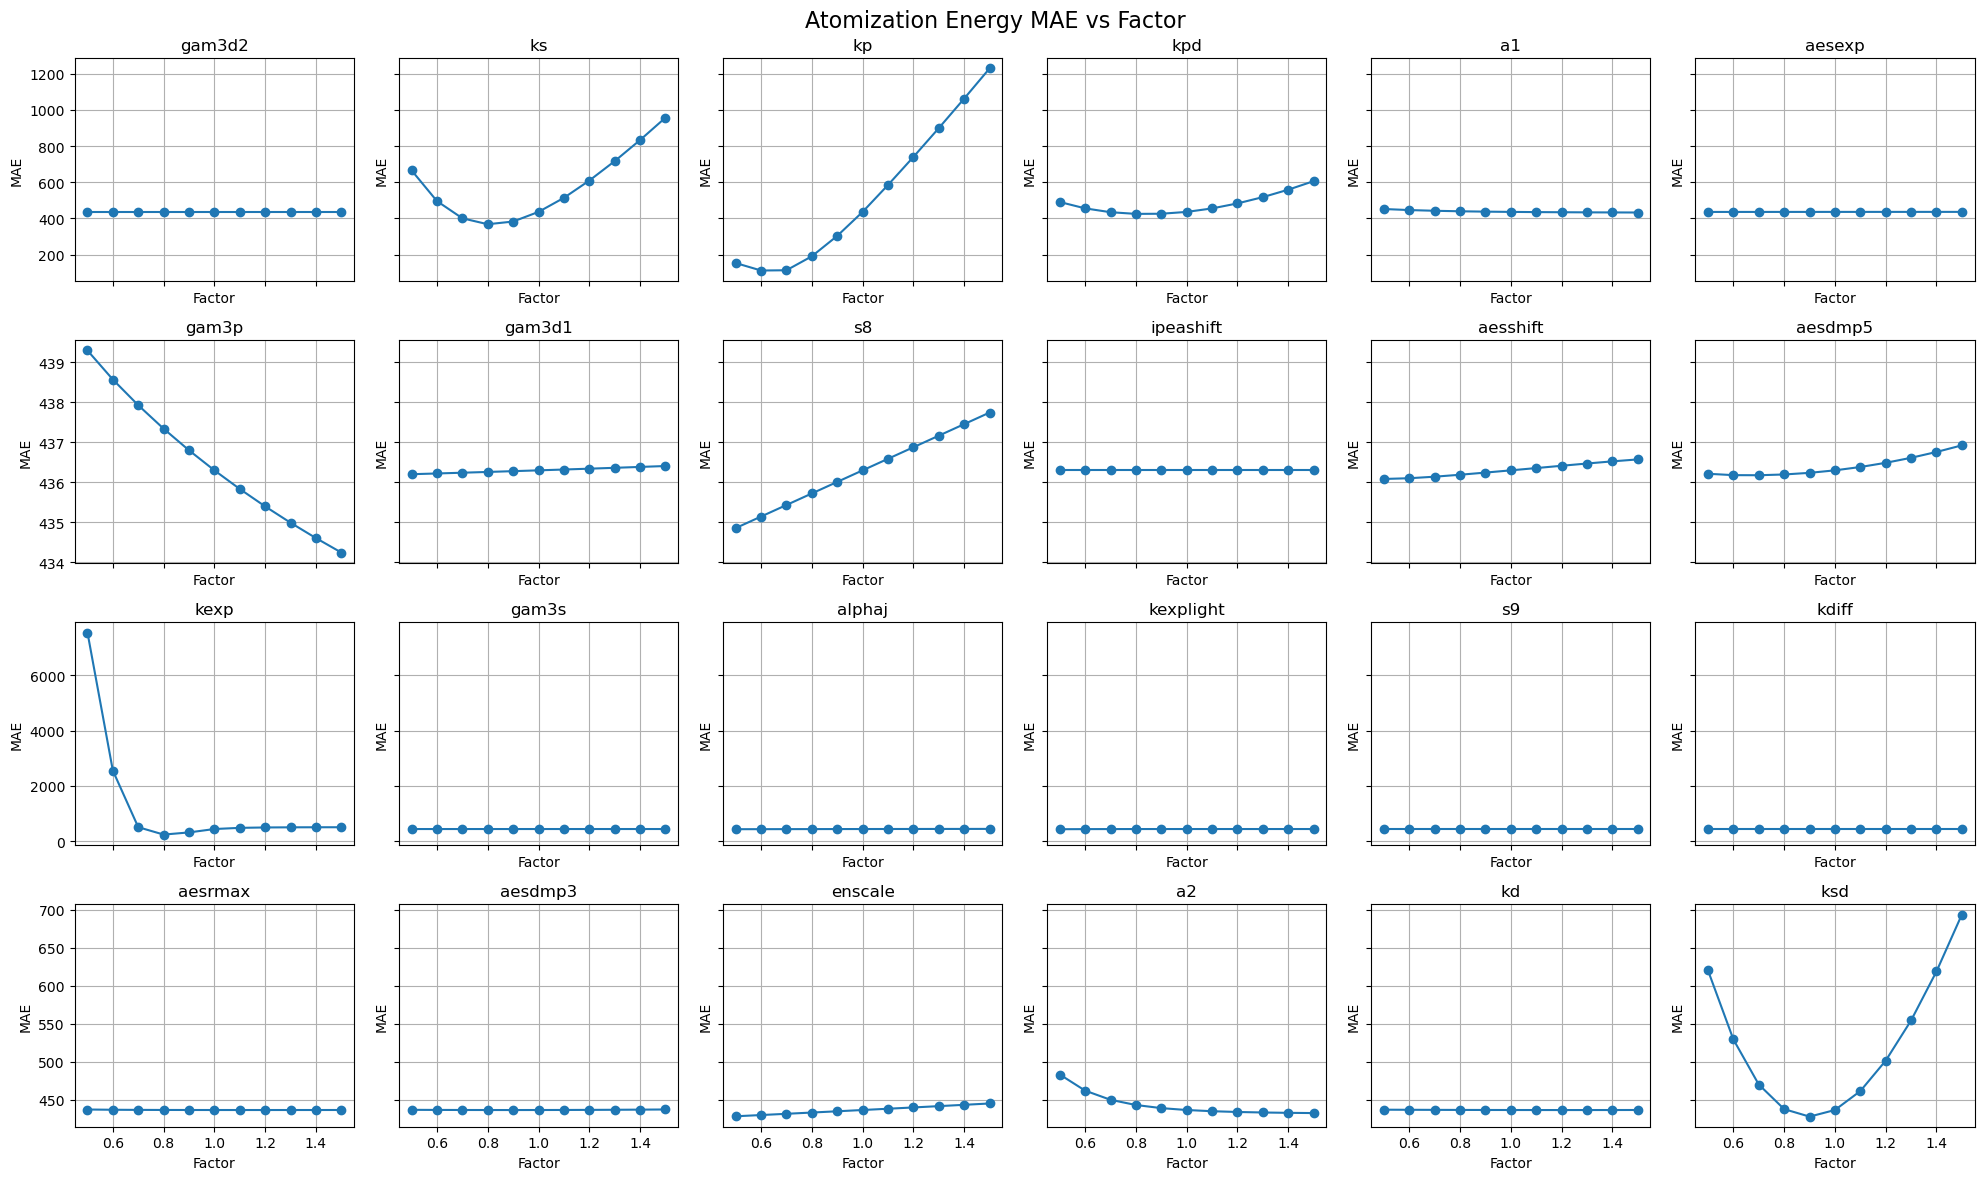

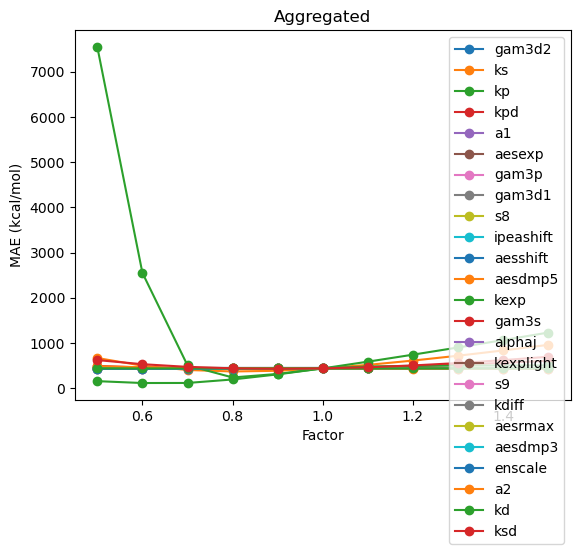

In [4]:
num_rows, num_cols = (4, 6)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 12), sharex=True, sharey="row")

aggregated_fig, aggregated_axs = plt.subplots()

successful_molecules = set(results_df["molecule"].unique())
for factor in results_df["factor"].unique():
    factor_df = results_df[results_df["factor"] == factor]
    for parameter in factor_df["parameter"].unique():
        parameter_df = factor_df[factor_df["parameter"] == parameter]
        successful_molecules = successful_molecules.intersection(
            set(parameter_df["molecule"].unique())
        )

for i, parameter in enumerate(results_df["parameter"].unique()):
    parameter_df = results_df[results_df["parameter"] == parameter]

    errors = []
    for j, factor in enumerate(parameter_df["factor"].unique()):
        factor_df = parameter_df[parameter_df["factor"] == factor]
        factor_df = factor_df[factor_df["molecule"].isin(successful_molecules)]

        errors.append(
            (factor, factor_df["Atomization Energy MAE (kcal/mol)"].abs().mean())
        )

    ax = axs[i // num_cols, i % num_cols]

    errors.sort(key=lambda x: x[0])

    ax.plot([x[0] for x in errors], [x[1] for x in errors], marker="o")
    aggregated_axs.plot(
        [x[0] for x in errors], [x[1] for x in errors], marker="o", label=parameter
    )

    ax.set_title(parameter)
    ax.set_xlabel("Factor")
    ax.set_ylabel("MAE")

    ax.grid(visible=True)

    aggregated_axs.set_title("Aggregated")
    aggregated_axs.set_xlabel("Factor")
    aggregated_axs.set_ylabel("MAE (kcal/mol)")
    aggregated_axs.legend()

fig.suptitle("Atomization Energy MAE vs Factor", fontsize=16)
fig.tight_layout()

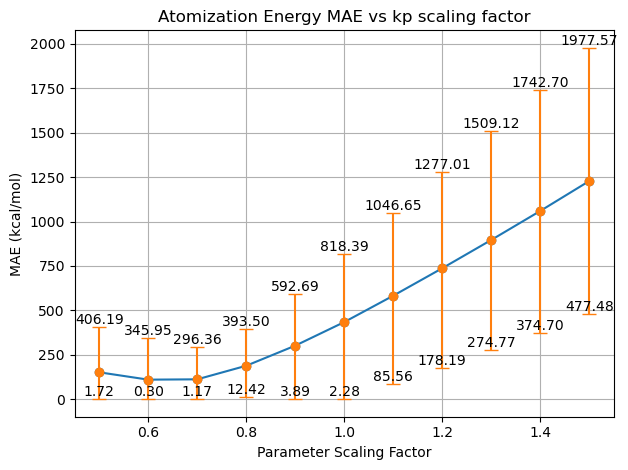

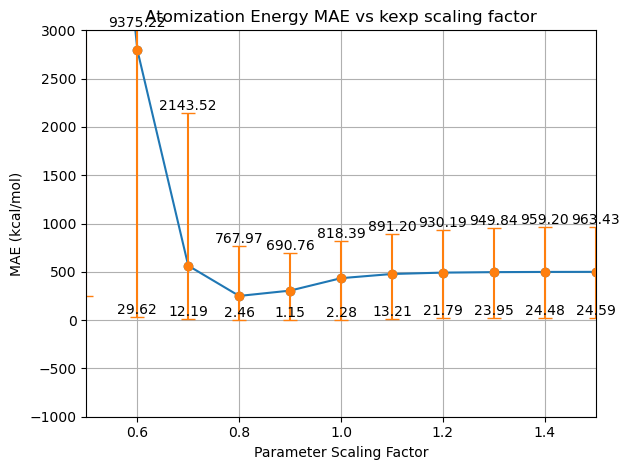

In [5]:
import matplotlib.pyplot as plt

selected_parameters = ["kp", "kexp"]

for i, parameter in enumerate(results_df["parameter"].unique()):
    if parameter not in selected_parameters:
        continue

    aggregated_fig, aggregated_axs = plt.subplots()

    parameter_df = results_df[results_df["parameter"] == parameter]

    errors = []
    max_errors = []
    min_errors = []
    for j, factor in enumerate(parameter_df["factor"].unique()):
        factor_df = parameter_df[parameter_df["factor"] == factor]

        mean_mae = factor_df["Atomization Energy MAE (kcal/mol)"].abs().mean()
        max_err = factor_df["Atomization Energy MAE (kcal/mol)"].abs().max() - mean_mae
        min_err = mean_mae - factor_df["Atomization Energy MAE (kcal/mol)"].abs().min()

        errors.append((factor, mean_mae))
        max_errors.append((factor, max_err))
        min_errors.append((factor, min_err))

    # Sort by factor value
    errors.sort(key=lambda x: x[0])
    max_errors.sort(key=lambda x: x[0])
    min_errors.sort(key=lambda x: x[0])

    x_vals = [x[0] for x in errors]
    y_vals = [x[1] for x in errors]

    # Plot the mean MAE with error bars
    aggregated_axs.plot(x_vals, y_vals, marker="o", label=parameter)
    aggregated_axs.errorbar(
        x_vals,
        y_vals,
        yerr=[[e[1] for e in min_errors], [e[1] for e in max_errors]],
        fmt="o",
        capsize=5,
    )

    # Add text annotations for error bar bounds
    for x, y in zip(x_vals, [y + e for y, (_, e) in zip(y_vals, max_errors)]):
        if parameter == "kexp" and x < 0.55:
            continue
        aggregated_axs.text(x, min(y, 3000), f"{y:.2f}", ha="center", va="bottom")

    for x, y in zip(x_vals, [y - e for y, (_, e) in zip(y_vals, min_errors)]):
        if parameter == "kexp" and x < 0.55:
            continue
        aggregated_axs.text(x, y, f"{y:.2f}", ha="center", va="bottom")

    if parameter == "kexp":
        aggregated_axs.set_xlim(
            min(parameter_df["factor"]), max(parameter_df["factor"])
        )
        aggregated_axs.set_ylim(-1000, 3000)

    aggregated_axs.grid(True)
    aggregated_axs.set_title(f"Atomization Energy MAE vs {parameter} scaling factor")
    aggregated_axs.set_xlabel("Parameter Scaling Factor")
    aggregated_axs.set_ylabel("MAE (kcal/mol)")
    # aggregated_axs.legend()

    aggregated_fig.tight_layout()

    aggregated_fig.savefig(
        processed_results_path / f"atomization_energy_mae_vs_factor_{parameter}.svg",
        format="svg",
    )
    plt.show()

## Geometry

In [6]:
# num_rows, num_cols = (4, 6)
# fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 12), sharex=True, sharey="row")

# aggregated_fig, aggregated_axs = plt.subplots()

# successful_molecules = set(results_df["molecule"].unique())
# for factor in results_df["factor"].unique():
#     factor_df = results_df[results_df["factor"] == factor]
#     for parameter in factor_df["parameter"].unique():
#         parameter_df = factor_df[factor_df["parameter"] == parameter]
#         successful_molecules = successful_molecules.intersection(
#             set(parameter_df["molecule"].unique())
#         )

# for i, parameter in enumerate(results_df["parameter"].unique()):
#     parameter_df = results_df[results_df["parameter"] == parameter]

#     errors = []
#     for j, factor in enumerate(parameter_df["factor"].unique()):
#         factor_df = parameter_df[parameter_df["factor"] == factor]
#         factor_df = factor_df[factor_df["molecule"].isin(successful_molecules)]

#         errors.append((factor, factor_df["Pairwise Distance MAE"].abs().mean()))

#     ax = axs[i // num_cols, i % num_cols]

#     errors.sort(key=lambda x: x[0])

#     ax.plot([x[0] for x in errors], [x[1] for x in errors], marker="o")
#     aggregated_axs.plot(
#         [x[0] for x in errors], [x[1] for x in errors], marker="o", label=parameter
#     )

#     ax.set_title(parameter)
#     ax.set_xlabel("Factor")
#     ax.set_ylabel("MAE")

#     ax.grid(visible=True)

#     aggregated_axs.set_title("Aggregated")
#     aggregated_axs.set_xlabel("Factor")
#     aggregated_axs.set_ylabel("MAE")
#     aggregated_axs.legend()

# fig.suptitle("Pairwise Distance MAE vs Factor", fontsize=16)
# fig.tight_layout()

In [7]:
# num_rows, num_cols = (4, 6)
# fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 12), sharex=True, sharey="row")

# aggregated_fig, aggregated_axs = plt.subplots()

# successful_molecules = set(results_df["molecule"].unique())
# for factor in results_df["factor"].unique():
#     factor_df = results_df[results_df["factor"] == factor]
#     for parameter in factor_df["parameter"].unique():
#         parameter_df = factor_df[factor_df["parameter"] == parameter]
#         successful_molecules = successful_molecules.intersection(
#             set(parameter_df["molecule"].unique())
#         )

# for i, parameter in enumerate(results_df["parameter"].unique()):
#     parameter_df = results_df[results_df["parameter"] == parameter]

#     errors = []
#     for j, factor in enumerate(parameter_df["factor"].unique()):
#         factor_df = parameter_df[parameter_df["factor"] == factor]
#         factor_df = factor_df[factor_df["molecule"].isin(successful_molecules)]
#         errors.append(
#             (factor, factor_df["Pairwise Distance Frobenius Norm"].abs().mean())
#         )

#     ax = axs[i // num_cols, i % num_cols]
#     errors.sort(key=lambda x: x[0])

#     x_vals = [x[0] for x in errors]
#     y_vals = [x[1] for x in errors]

#     # Plot points
#     ax.plot(x_vals, y_vals, marker="o")
#     aggregated_axs.plot(x_vals, y_vals, marker="o", label=parameter)

#     # Add text labels to each point
#     for x, y in zip(x_vals, y_vals):
#         ax.text(x, y, f"{y:.4f}", ha="center", va="bottom", fontsize=8)
#         aggregated_axs.text(x, y, f"{y:.4f}", ha="center", va="bottom", fontsize=8)

#     ax.set_title(parameter)
#     ax.set_xlabel("Factor")
#     ax.set_ylabel("MAE")
#     ax.grid(visible=True)

#     aggregated_axs.set_title("Aggregated")
#     aggregated_axs.set_xlabel("Factor")
#     aggregated_axs.set_ylabel("Frobenius Norm")
#     aggregated_axs.legend()

# fig.suptitle("Pairwise Distance Frob vs Factor", fontsize=16)
# fig.tight_layout()

## Maximum Atomic Force

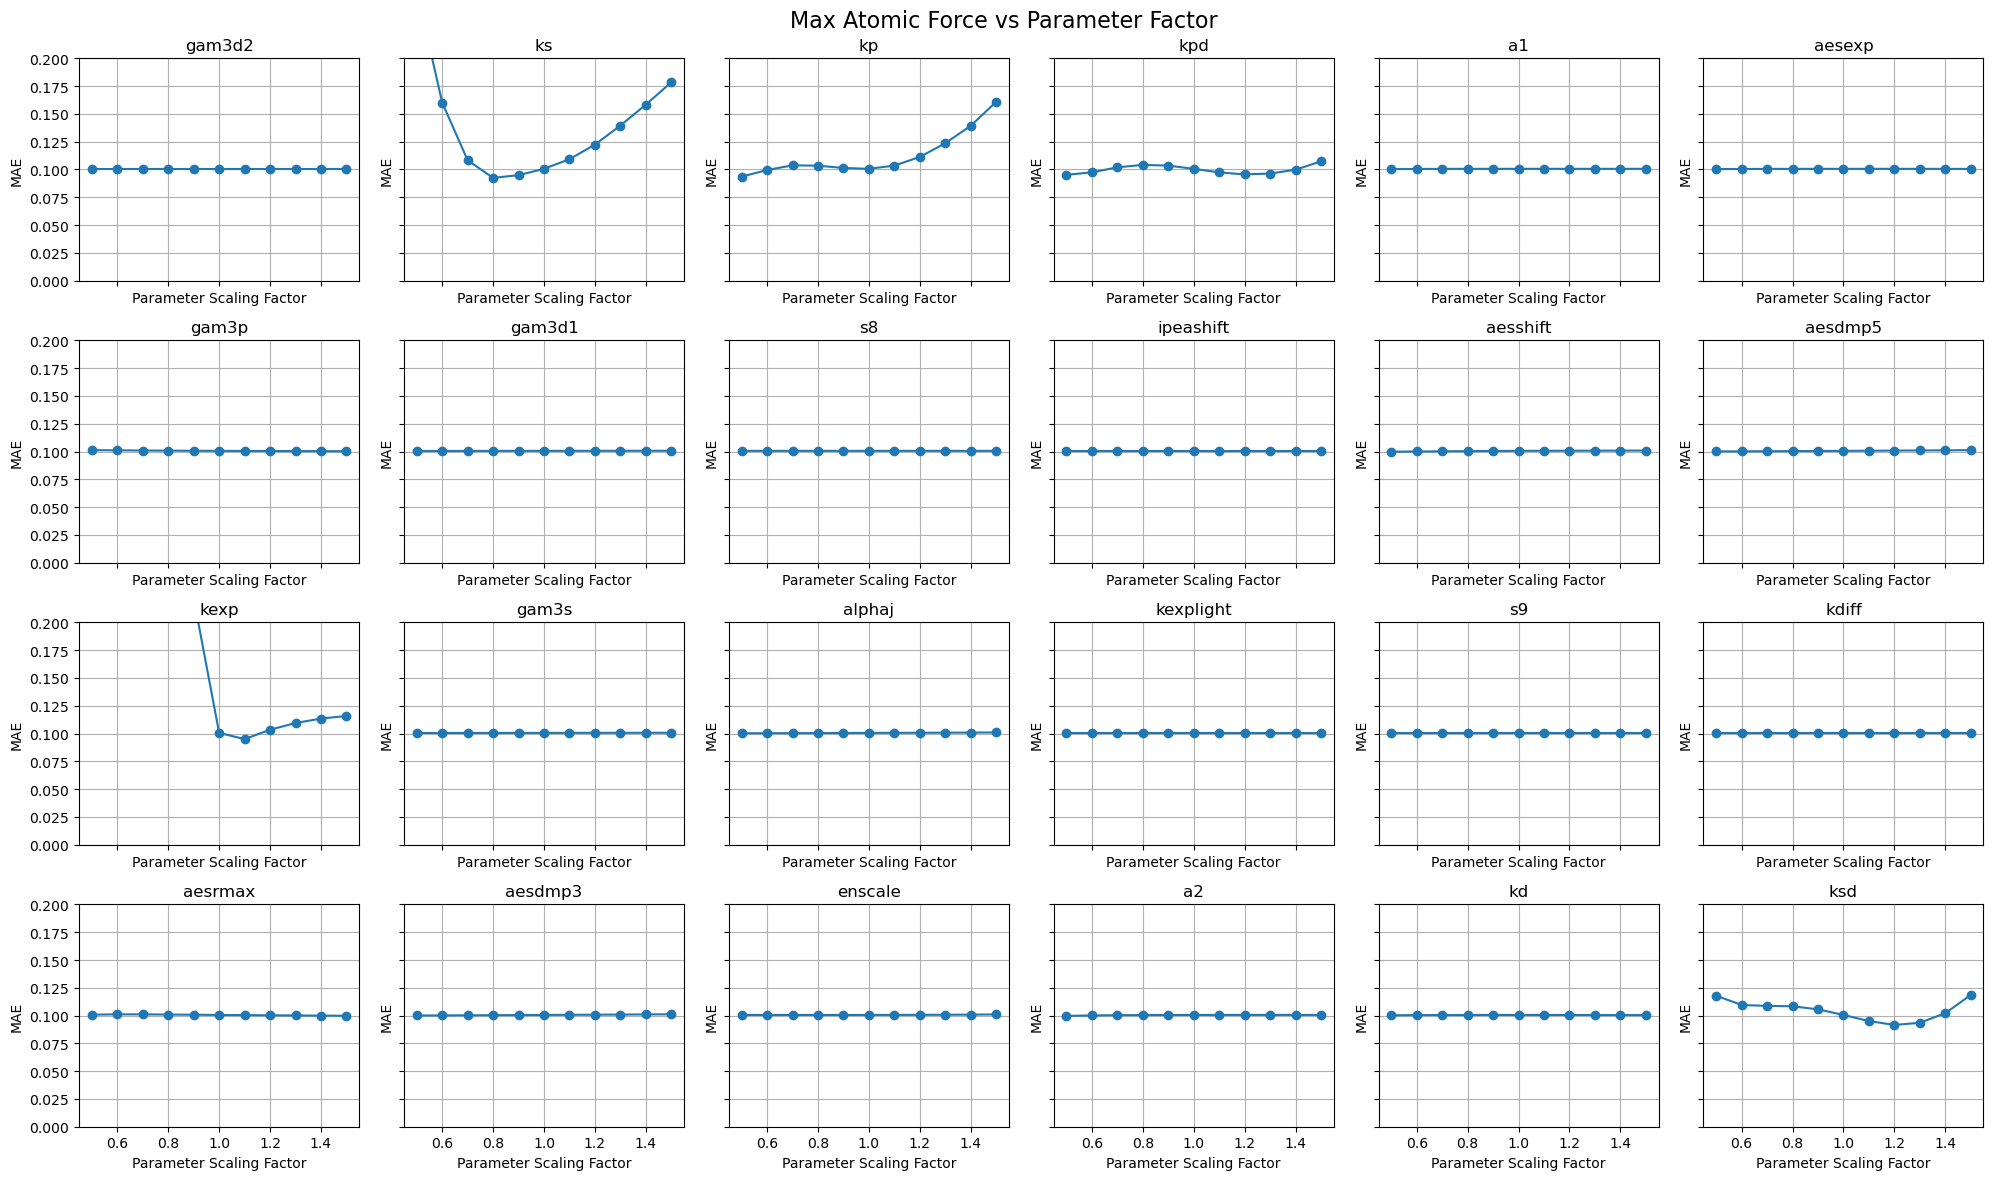

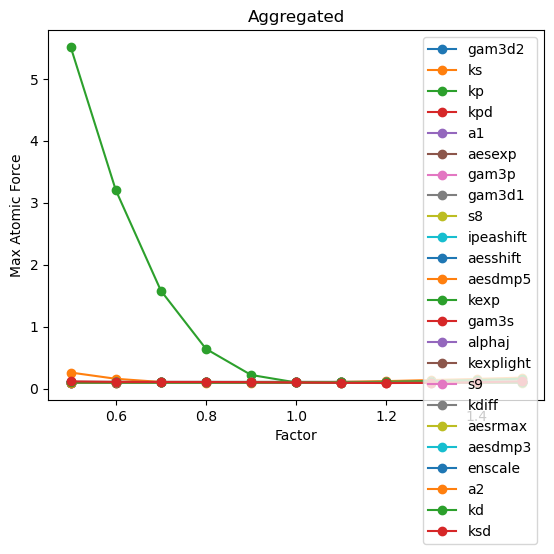

In [8]:
num_rows, num_cols = (4, 6)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 12), sharex=True, sharey="row")

aggregated_fig, aggregated_axs = plt.subplots()

successful_molecules = set(results_df["molecule"].unique())
for factor in results_df["factor"].unique():
    factor_df = results_df[results_df["factor"] == factor]
    for parameter in factor_df["parameter"].unique():
        parameter_df = factor_df[factor_df["parameter"] == parameter]
        successful_molecules = successful_molecules.intersection(
            set(parameter_df["molecule"].unique())
        )

for i, parameter in enumerate(results_df["parameter"].unique()):
    parameter_df = results_df[results_df["parameter"] == parameter]

    errors = []
    for j, factor in enumerate(parameter_df["factor"].unique()):
        factor_df = parameter_df[parameter_df["factor"] == factor]
        factor_df = factor_df[factor_df["molecule"].isin(successful_molecules)]

        errors.append((factor, factor_df["max atomic force"].abs().mean()))

    ax = axs[i // num_cols, i % num_cols]

    errors.sort(key=lambda x: x[0])

    ax.plot([x[0] for x in errors], [x[1] for x in errors], marker="o")
    aggregated_axs.plot(
        [x[0] for x in errors], [x[1] for x in errors], marker="o", label=parameter
    )

    ax.set_title(parameter)
    ax.set_xlabel("Parameter Scaling Factor")
    ax.set_ylabel("MAE")

    ax.set_ylim(0, 0.2)

    ax.grid(visible=True)

    aggregated_axs.set_title("Aggregated")
    aggregated_axs.set_xlabel("Factor")
    aggregated_axs.set_ylabel("Max Atomic Force")
    aggregated_axs.legend()

fig.suptitle("Max Atomic Force vs Parameter Factor", fontsize=16)
fig.tight_layout()